## Data Processing

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/nfl_scores_processed.csv')

# drop the 'schedule_date', 'over_under_line' and all weather related columns
df = df.drop(['schedule_date', 'over_under_line', 'weather_detail', 'weather_temperature', 'weather_wind_mph', 'weather_humidity'], axis=1)

# drop all rows with 'winner' = tie
df = df[df['winner'] != 'tie']

# home/away encoding
home_away_encoder = {'home': 0, 'away': 1 ,'PICK': 0.5}

# win/loss encoding
win_loss_encoder = {'win': 1, 'loss': 0, 'tie': 0.5}

# schedule playoff encoding
schedule_playoff_encoder = {'Wildcard': 1, 'Division': 2, 'Conference': 3, 'Superbowl': 4}

# create reverse encoders
home_away_decoder = {v: k for k, v in home_away_encoder.items()}
win_loss_decoder = {v: k for k, v in win_loss_encoder.items()}
schedule_playoff_decoder = {v: k for k, v in schedule_playoff_encoder.items()}

# week replacements for postseason
df['schedule_week'] = df['schedule_week'].replace('Wildcard', '1')
df['schedule_week'] = df['schedule_week'].replace('Division', '2')
df['schedule_week'] = df['schedule_week'].replace('Conference', '3')
df['schedule_week'] = df['schedule_week'].replace('Superbowl', '4')

# convert the 'schedule_week' column to int
df['schedule_week'] = df['schedule_week'].astype(int)

# one hot encode the 'team_home' and 'team_away' columns
df = pd.get_dummies(df, columns=['team_home', 'team_away'])

# convert the 'team_favorite_id' column to 0 (home), 1 (away), 0.5 (PICK)
df['team_favorite_id'] = df['team_favorite_id'].replace(home_away_encoder)

# convert the 'winner' column to 0 (home) or 1 (away), 0.5 (tie)
df['winner'] = df['winner'].replace(home_away_encoder)

# convert the home_1, ..., home_10 columns to 0 (loss), 1 (win) or 0.5 (tie), same for away
for i in range(1, 11):
    df['home_' + str(i)] = df['home_' + str(i)].replace(win_loss_encoder)
    df['away_' + str(i)] = df['away_' + str(i)].replace(win_loss_encoder)

# replace 'NaN' string with np.nan
df = df.replace('NaN', np.nan)

# drop all rows with 'NaN' values (games for which fewer than 10 games of history are available)
df = df.dropna()

# show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# save the processed df to a csv file
df.to_csv('data/nfl_scores_processed_for_LR.csv', index=False)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('winner', axis=1), df['winner'], test_size=0.2, random_state=42)


## Model Training

In [14]:
from sklearn.linear_model import LogisticRegression
import shap
shap.initjs()
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

# Create a Shap explainer
explainer = shap.LinearExplainer(model,X_train,feature_names=X_train.columns)

# Generate SHAP values for X_test
shap_values = explainer(X_test)



Accuracy: 0.7669


## Visualization Individual Instance

In [15]:
# define a function to get the shap waterfall plot for a specific index
def get_waterfall_plot(index):
    shap.plots.waterfall(shap_values[index], max_display=10)

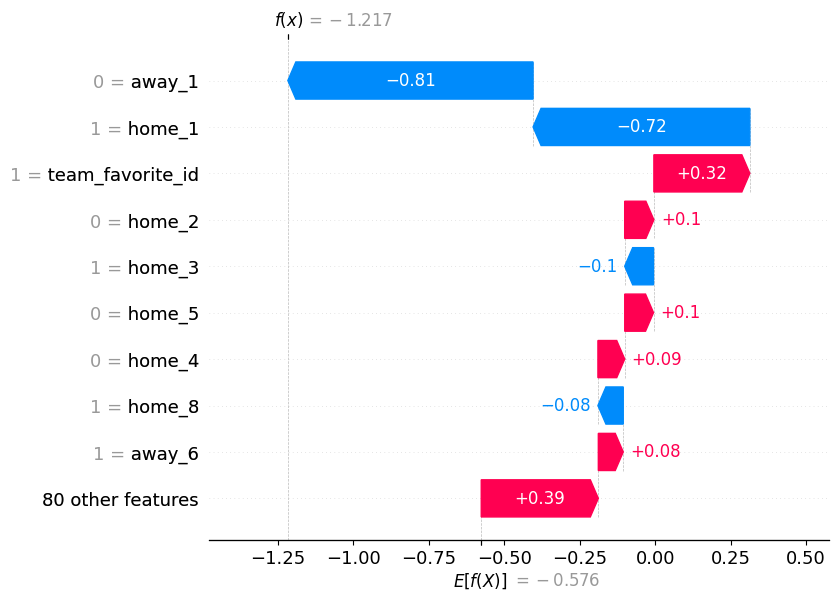

In [16]:
get_waterfall_plot(5)


## Visualization Full Model

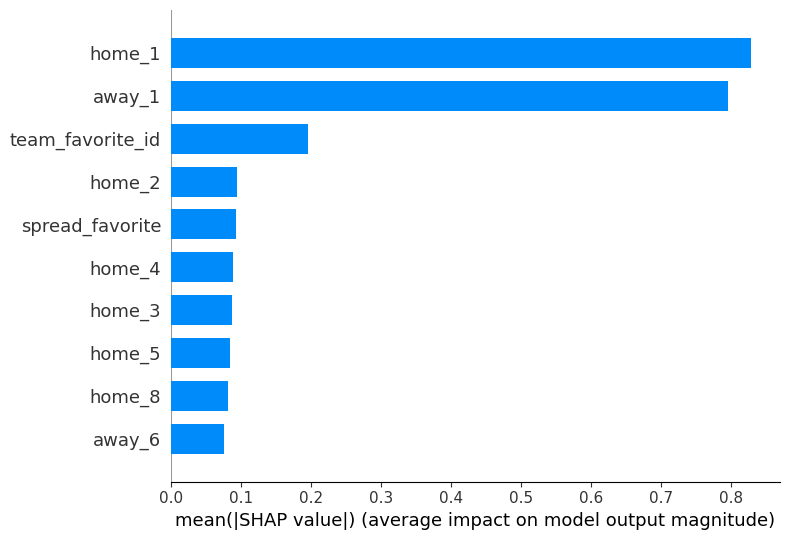

In [17]:
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, plot_type="bar", max_display=10)